<a href="https://colab.research.google.com/github/teogenesmoura/soccer_shirt_recognition/blob/main/soccer_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.2 MB/s eta 0:00:00


In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

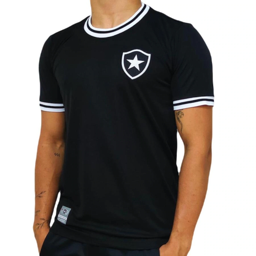

In [3]:
# Since Botafogo is a brazilian club, we'll have the search query be in Brazilian Portuguese. "camisa botafogo" translates to "botafogo shirt"
urls = search_images('camisa botafogo', max_images=1)

from fastdownload import download_url
dest = 'botafogo_camisa.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


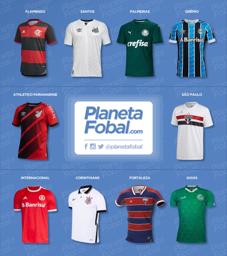

In [4]:
# Likewise the above query, 'camisas time brasileirao' roughly translates to 'soccer shirts brazilian league'
download_url(search_images('camisas time brasileirao serie a', max_images=1)[0], 'generic_team_shirt.jpg', show_progress=False)
Image.open('generic_team_shirt.jpg').to_thumb(256,256)

In [7]:
searches = 'camisa botafogo','camisas time brasileirao serie a'
path = Path('botafogo_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print("Images failed:" + str(len(failed)))
print("Sucessful images:" + str(len(get_image_files(path))))

Images failed:5
Sucessful images:379


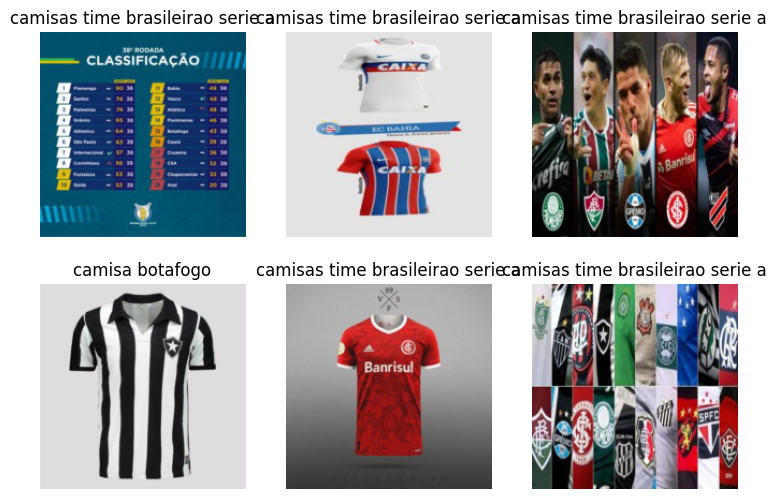

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.944917,0.495228,0.133333,00:50


epoch,train_loss,valid_loss,error_rate,time
0,0.354856,0.161574,0.080000,01:13
1,0.230916,0.090551,0.040000,01:09
2,0.165510,0.099990,0.040000,01:13


In [11]:
is_botafogo,_,probs = learn.predict(PILImage.create('botafogo_camisa.jpg'))
print(f"This is a: {is_botafogo}.")
print(f"Probability it's a botafogo shirt: {probs[0]:.4f}")

This is a: camisa botafogo.
Probability it's a botafogo shirt: 0.9949


In [12]:
download_url(search_images('shirt juventus italy 2024/25', max_images=20)[0], 'juventus_shirt.jpg', show_progress=False)

Path('juventus_shirt.jpg')

In [14]:
is_botafogo,_,probs = learn.predict(PILImage.create('juventus_shirt.jpg'))
print(f"This is a: {is_botafogo}.")
print(f"Probability it's a botafogo shirt: {probs[0]:.4f}")

This is a: camisa botafogo.
Probability it's a botafogo shirt: 0.8425
